In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  
 
import os 
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib import gridspec

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
 
import IPython
from sklearn import linear_model, svm

import data_utils as data
import datasets
import upper_bounds
import plotter
import defenses
from upper_bounds import hinge_loss, hinge_grad

sns.set_style(style='white')
sns.set(color_codes=True)
sns.set(font_scale=1.5)
palette = sns.color_palette()
plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def annotate_upper_left(ax, text):    
    ax.annotate(text, xy=(0, 1), xycoords='axes fraction', fontsize=18,
        xytext=annotation_offset, textcoords='offset points',
        ha='left', va='top')
    
def train_svm(X_train, Y_train, weight_decay):
    C = 1.0 / (X_train.shape[0] * weight_decay)        
    svm_model = svm.LinearSVC(
        C=C,
        tol=1e-7,
        loss='hinge',
        fit_intercept=True,
        random_state=24,
        max_iter=10000,
        verbose=True)

    svm_model.fit(X_train, Y_train)
    params = np.reshape(svm_model.coef_, -1)
    bias = svm_model.intercept_[0]
    
    return params, bias


In [3]:
# fig_root = '/afs/cs.stanford.edu/u/jsteinhardt/www/reports/figs'
fig_root = '.'
# os.makedirs(fig_root)
fig_size = (6, 5)
wide_fig_size = (16, 5)
wide_short_fig_size = (16, 3)
annotation_offset = (-50, 22)

### Figure 1 -- Visualizing slab vs sphere

In [5]:
dataset_name = 'mnist_17'
X_train, Y_train, X_test, Y_test = datasets.load_dataset(dataset_name)
class_map, centroids, centroid_vec, sphere_radii, slab_radii = data.get_data_params(X_train, Y_train, percentile=70)

norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
standard_bounds_path = datasets.get_bounds_path(dataset_name, norm_sq_constraint)
standard_f = np.load(standard_bounds_path)

standard_epsilons = standard_f['epsilons']
lower_weight_decays = standard_f['lower_weight_decays']
clean_weight_decay = lower_weight_decays[0] 
assert standard_epsilons[0] == 0

params_orig, bias_orig = train_svm(X_train, Y_train, clean_weight_decay)  

epsilon = 0.3
attack_filename = datasets.get_attack_npz_filename(dataset_name, epsilon, norm_sq_constraint) 
X_modified, Y_modified, X_test, Y_test, idx_train, idx_poison = datasets.load_attack_npz(
    dataset_name, 
    attack_filename)
X_poison = X_modified[idx_poison, :]
Y_poison = Y_modified[idx_poison]
assert np.all(X_modified[idx_train, :] == X_train)
assert np.all(Y_modified[idx_train] == Y_train)

IOError: [Errno 2] No such file or directory: u'./data/mnist_17_train_test.npz'

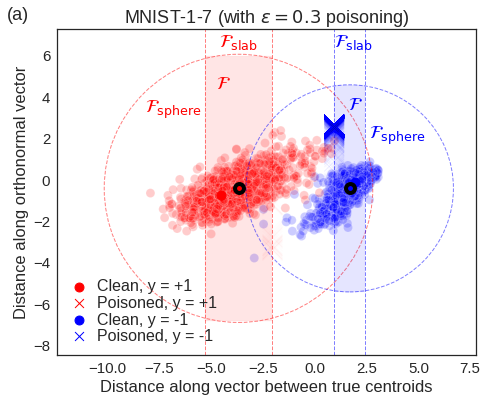

In [11]:
plot = plotter.Plotter(
    X_train,
    axes=np.concatenate(
        (np.reshape(centroid_vec, (1, -1)),
        np.reshape(params_orig, (1, -1))), 
        axis=0),
    figsize=(7.5, 6),
    padding=4.5)

### For legend
plot.plot_points_poison(
    X_train[4:5, :], Y_train[4:5], 
    linewidth=1, alpha=1,
    poscolor='red',
    negcolor='blue',
    edgecolor=None,
    marker='o',
    size=80,
    label='Clean, y = +1') 
plot.plot_points_poison(
    X_poison[0:1, :], [1], 
    linewidth=1, alpha=1,
    poscolor='red',
    negcolor='blue',
    marker='x',
    size=80,
    label='Poisoned, y = +1')

plot.plot_points_poison(
    X_train[0:1, :], Y_train[0:1], 
    linewidth=1, alpha=1,
    poscolor='red',
    negcolor='blue',
    edgecolor=None,
    marker='o',
    size=80,
    label='Clean, y = -1') 
plot.plot_points_poison(
    X_poison[0:1, :], Y_poison[0:1], 
    linewidth=1, alpha=1,
    poscolor='red',
    negcolor='blue',
    marker='x',
    size=80,
    label='Poisoned, y = -1') 
###

plot.plot_points_train(X_train, Y_train, alpha=0.2, subsample=0.15)
poison_idx_start = 0
poison_idx_end = X_poison.shape[0]
plot.plot_points_poison(
    X_poison[poison_idx_start:poison_idx_end, :], Y_poison[poison_idx_start:poison_idx_end], 
    linewidth=1, alpha=0.01,
    poscolor='red',
    negcolor='blue',
    marker='x',
    size=400)

plt.xlabel('Distance along vector between true centroids')
plt.ylabel('Distance along orthonormal vector')

for y in set(Y_train):
    class_idx = class_map[y]
    if y == 1:
        color = 'red'
    else:
        color = 'blue'
    
    centroid = centroids[class_idx, :]
    slab_radius = slab_radii[class_idx]
    sphere_radius = sphere_radii[class_idx]

    plot.plot_points_poison(centroid, [y], linewidth=4, alpha=1, marker='o')
    centroid_left = plot.proj(centroid, 0) - slab_radius
    centroid_right = plot.proj(centroid, 0) + slab_radius

    plot.draw_line(x0=centroid_left, x1=centroid_left, color=color, alpha=0.5, linestyle='--', linewidth=1)
    plot.draw_line(x0=centroid_right, x1=centroid_right, color=color, alpha=0.5, linestyle='--', linewidth=1)
    if y == 1:
        slab_height = 6.4
        wedge_deg = 15
    else:
        slab_height = 5
        wedge_deg = 12
    proj_centroid = plot.proj(centroid)

    rect = patches.Rectangle(
        (proj_centroid[0] - slab_radius, proj_centroid[1] - slab_height), 
        slab_radius * 2, slab_height * 2,
        color=color,
        alpha=0.1)

    circle = plt.Circle(
        proj_centroid, sphere_radius, 
        fill=False, edgecolor=color, linewidth=1, linestyle='--', alpha=0.5)
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(rect)
    ax.add_artist(circle)
    
ax = plt.gcf().gca()
ax.annotate('$\mathcal{F}_\mathrm{sphere}$', xy=(0.33, 0.72), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='red')
ax.annotate('$\mathcal{F}_\mathrm{slab}$', xy=(0.505, 0.92), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='red')
ax.annotate('$\mathcal{F}$', xy=(0.5, 0.79), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='red')

ax.annotate('$\mathcal{F}_\mathrm{sphere}$', xy=(0.865, 0.64), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='blue')
ax.annotate('$\mathcal{F}_\mathrm{slab}$', xy=(0.781, 0.92), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='blue')
ax.annotate('$\mathcal{F}$', xy=(0.815, 0.725), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='blue')

annotate_upper_left(ax, '(a)')

plt.title('MNIST-1-7 (with $\epsilon=0.3$ poisoning)')
plt.legend(fontsize=16, bbox_to_anchor=(-0.02, -0.01), loc='lower left',
           labelspacing=0.1, handletextpad=0.1)
plt.rcParams['font.sans-serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = 'serif'
plt.savefig(
    os.path.join(fig_root, 'paper-fig1a.pdf'), 
    dpi=300, bbox_inches='tight')

In [93]:
dataset_name = 'imdb'
X_train, Y_train, X_test, Y_test = datasets.load_dataset(dataset_name)
class_map, centroids, centroid_vec, sphere_radii, slab_radii = data.get_data_params(X_train, Y_train, percentile=70)

norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
standard_bounds_path = datasets.get_int_bounds_path(dataset_name, norm_sq_constraint)
standard_f = np.load(standard_bounds_path)

standard_epsilons = standard_f['epsilons']
lower_weight_decays = standard_f['lower_weight_decays']
clean_weight_decay = lower_weight_decays[0] 
assert standard_epsilons[0] == 0

params_orig, bias_orig = train_svm(X_train, Y_train, clean_weight_decay)  

epsilon = 0.05
attack_filename = datasets.get_int_attack_npz_filename(dataset_name, epsilon, norm_sq_constraint, percentile=10.0) 
X_modified, Y_modified, X_test, Y_test, idx_train, idx_poison = datasets.load_attack_npz(
    dataset_name, 
    attack_filename)
X_poison = X_modified[idx_poison, :]
Y_poison = Y_modified[idx_poison]
assert (X_modified[idx_train, :] - X_train).nnz == 0
assert np.all(Y_modified[idx_train] == Y_train)

[LibLinear]

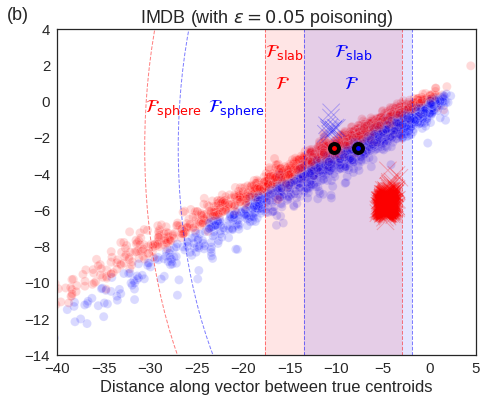

In [94]:
plot = plotter.Plotter(
    X_train,
    axes=np.concatenate(
        (np.reshape(centroid_vec, (1, -1)),
        np.reshape(params_orig, (1, -1))), 
        axis=0),
    figsize=(7.5, 6),
    padding=4.5)

plot.plot_points_train(X_train, Y_train, alpha=0.15, subsample=0.2)
poison_idx_start = 0
poison_idx_end = int(np.round(X_poison.shape[0] / 2))

plot.plot_points_poison(
    X_poison[poison_idx_start:poison_idx_end, :], Y_poison[poison_idx_start:poison_idx_end], 
    linewidth=1, alpha=0.25,
    poscolor='red',
    negcolor='blue',
    marker='x',
    size=300)
plt.xlabel('Distance along vector between true centroids')
# plt.ylabel('Distance along orthonormal vector')

plt.xlim(((-40, 5)))
plt.ylim(((-14, 4)))
for y in set(Y_train):
    class_idx = class_map[y]
    if y == 1:
        color = 'red'
    else:
        color = 'blue'
    
    centroid = centroids[class_idx, :]
    slab_radius = slab_radii[class_idx]
    sphere_radius = sphere_radii[class_idx]
    
    plot.plot_points_poison(centroid, [y], linewidth=4, alpha=1, marker='o')
    centroid_left = plot.proj(centroid, 0) - slab_radius
    centroid_right = plot.proj(centroid, 0) + slab_radius

    plot.draw_line(x0=centroid_left, x1=centroid_left, color=color, alpha=0.5, linestyle='--', linewidth=1)
    plot.draw_line(x0=centroid_right, x1=centroid_right, color=color, alpha=0.5, linestyle='--', linewidth=1)
    if y == 1:
        slab_height = 15
        wedge_deg = 15
    else:
        slab_height = 15
        wedge_deg = 12
    proj_centroid = plot.proj(centroid)

    rect = patches.Rectangle(
        (proj_centroid[0] - slab_radius, proj_centroid[1] - slab_height), 
        slab_radius * 2, slab_height * 2,
        color=color,
        alpha=0.1)

    wedge_top = patches.Wedge(
        proj_centroid,
        sphere_radius,
        90 - wedge_deg,
        90 + wedge_deg,
        color=color,
        alpha=0.1
    )
    wedge_bottom = patches.Wedge(
        proj_centroid,
        sphere_radius,
        270 - wedge_deg,
        270 + wedge_deg,
        color=color,
        alpha=0.1    
    )
    
    circle = plt.Circle(
        proj_centroid, sphere_radius, 
        fill=False, edgecolor=color, linewidth=1, linestyle='--', alpha=0.5)
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(rect)  
    ax.add_artist(circle)
    

ax = plt.gcf().gca()
ax.annotate('$\mathcal{F}_\mathrm{sphere}$', xy=(0.33, 0.72), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='red')
ax.annotate('$\mathcal{F}_\mathrm{slab}$', xy=(0.615, 0.89), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='red')
ax.annotate('$\mathcal{F}$', xy=(0.64, 0.79), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='red')

ax.annotate('$\mathcal{F}_\mathrm{sphere}$', xy=(0.48, 0.72), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='blue')
ax.annotate('$\mathcal{F}_\mathrm{slab}$', xy=(0.780, 0.89), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='blue')
ax.annotate('$\mathcal{F}$', xy=(0.805, 0.79), xycoords='axes fraction', fontsize=18,
    xytext=annotation_offset, textcoords='offset points',
    ha='left', va='top', color='blue')

plt.title('IMDB (with $\epsilon=0.05$ poisoning)')
annotate_upper_left(ax, '(b)')
plt.rcParams['font.sans-serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = 'serif'
plt.savefig(
    os.path.join(fig_root, 'paper-fig1b.pdf'), 
    dpi=300, bbox_inches='tight')

### Figure 2 -- Standard vs. baseline, dogfish and mnist

In [24]:
dataset_name = 'dogfish'
norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
f = np.load(datasets.get_bounds_path(dataset_name, norm_sq_constraint))

dogfish_epsilons = f['epsilons']
dogfish_lower_total_train_losses = f['lower_total_train_losses']
dogfish_lower_avg_good_train_losses = f['lower_avg_good_train_losses']
dogfish_upper_total_losses = f['upper_total_losses']
dogfish_lower_test_losses = f['lower_test_losses']

dataset_name = 'mnist_17'
norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
f = np.load(datasets.get_bounds_path(dataset_name, norm_sq_constraint))

mnist_epsilons = f['epsilons']
mnist_lower_total_train_losses = f['lower_total_train_losses']
mnist_lower_avg_good_train_losses = f['lower_avg_good_train_losses']
mnist_upper_total_losses = f['upper_total_losses']
mnist_lower_test_losses = f['lower_test_losses']
mnist_lower_test_acc = f['lower_test_acc']
print('Dataset     : %s' % dataset_name)

gradient_bounds_path = datasets.get_grad_bounds_path(dataset_name, norm_sq_constraint)
gradient_f = np.load(gradient_bounds_path)
labelflip_bounds_path = datasets.get_labelflip_bounds_path(dataset_name, norm_sq_constraint)
labelflip_f = np.load(labelflip_bounds_path)

Dataset     : mnist_17


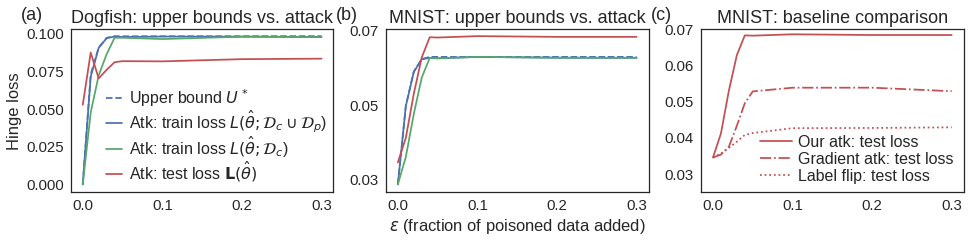

In [26]:
sns.set_style(style='white')

f, axs = plt.subplots(1, 3, figsize=wide_short_fig_size)

# annotate_upper_left(axs[0], '(a)')
axs[0].set_title('(a) Dogfish: upper bounds vs. attack', fontsize=14)
axs[0].plot(dogfish_epsilons, dogfish_upper_total_losses, label='Upper bound $U^*$', linestyle='--', color=palette[0])
axs[0].plot(dogfish_epsilons, dogfish_lower_total_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c \cup \mathcal{D}_p$)', color=palette[0])
axs[0].plot(dogfish_epsilons, dogfish_lower_avg_good_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c$)', color=palette[1])
axs[0].plot(dogfish_epsilons, dogfish_lower_test_losses, label='Atk: test loss $\mathbf{L}(\hat\\theta)$', color=palette[2])
axs[0].set_ylabel('Hinge loss')
axs[0].legend(fontsize=14, bbox_to_anchor=(0.08, -0.04), loc='lower left',
              labelspacing=0, handletextpad=0.4, handlelength=1)

# annotate_upper_left(axs[1], '(b)')
axs[1].set_title('(b) MNIST: upper bounds vs. attack', fontsize=14)
axs[1].plot(mnist_epsilons, mnist_upper_total_losses, label='Upper bound $U^*$', linestyle='--', color=palette[0])
axs[1].plot(mnist_epsilons, mnist_lower_total_train_losses, label='Lower: train loss ($\mathcal{D}_c \cup \mathcal{D}_p$)', color=palette[0])
axs[1].plot(mnist_epsilons, mnist_lower_avg_good_train_losses, label='Lower: train loss ($\mathcal{D}_c$)', color=palette[1])
axs[1].plot(mnist_epsilons, mnist_lower_test_losses, label='Lower: test loss ', color=palette[2])
axs[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
for label in axs[1].get_yticklabels()[::2]:
    label.set_visible(False)
axs[1].set_xlabel('$\epsilon$ (fraction of poisoned data added)')

# annotate_upper_left(axs[2], '(c)')
axs[2].set_title('(c) MNIST: baseline comparison', fontsize=14)
axs[2].plot(mnist_epsilons, mnist_lower_test_losses, label='Our atk: test loss', color=palette[2])
axs[2].plot(mnist_epsilons, gradient_f['lower_test_losses'], label='Gradient atk: test loss', linestyle='-.', color=palette[2])
axs[2].plot(mnist_epsilons, labelflip_f['lower_test_losses'], label='Label flip: test loss', linestyle=':', color=palette[2])
axs[2].set_ylim((0.025, 0.07))
leg = axs[2].legend(bbox_to_anchor = [0.17, -0.04], loc='lower left', fontsize=14,
              labelspacing=0.15, handletextpad=0.4)

plt.rcParams['font.sans-serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = 'serif'
plt.savefig(
    os.path.join(fig_root, 'paper-fig2.pdf'), 
    dpi=300, bbox_inches='tight')

### Figure 3 -- Standard vs. feasible, enron and imdb

In [22]:
dataset_name = 'enron'
norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
f = np.load(datasets.get_bounds_path(dataset_name, norm_sq_constraint))

enron_epsilons = f['epsilons']
enron_upper_total_losses = f['upper_total_losses']

feas_f = np.load(datasets.get_int_bounds_path(dataset_name, norm_sq_constraint))

assert np.all(feas_f['epsilons'] == f['epsilons'])
enron_feas_lower_test_losses = feas_f['lower_test_losses']
enron_feas_lower_total_train_losses = feas_f['lower_total_train_losses']
enron_feas_lower_test_acc = feas_f['lower_test_acc']
enron_feas_lower_avg_good_train_losses = feas_f['lower_avg_good_train_losses']

dataset_name = 'imdb'
norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
f = np.load(datasets.get_bounds_path(dataset_name, norm_sq_constraint))

imdb_epsilons = f['epsilons']
imdb_upper_total_losses = f['upper_total_losses']

feas_f = np.load(datasets.get_int_bounds_path(dataset_name, norm_sq_constraint))

assert np.all(feas_f['epsilons'] == f['epsilons'])
imdb_feas_lower_test_losses = feas_f['lower_test_losses']
imdb_feas_lower_total_train_losses = feas_f['lower_total_train_losses']
imdb_feas_lower_test_acc = feas_f['lower_test_acc']
imdb_feas_lower_avg_good_train_losses = feas_f['lower_avg_good_train_losses']

labelflip_bounds_path = datasets.get_labelflip_bounds_path(dataset_name, norm_sq_constraint)
labelflip_f = np.load(labelflip_bounds_path)

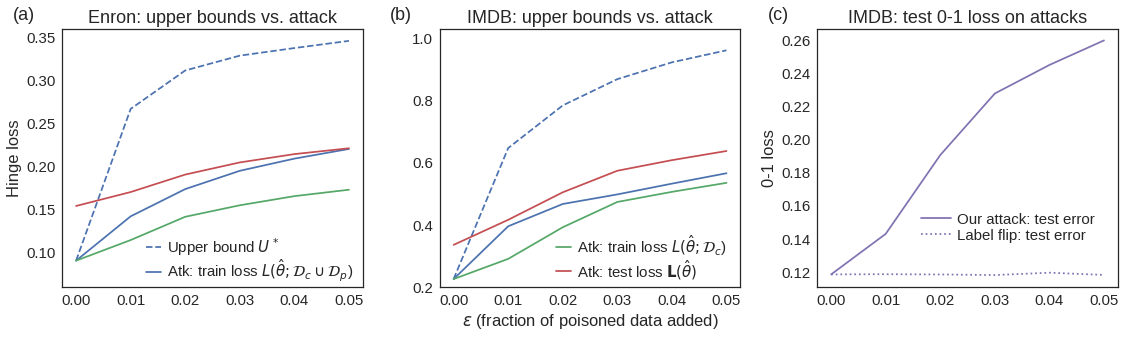

In [23]:
f, axs = plt.subplots(1, 3, figsize=wide_fig_size)

# annotate_upper_left(axs[0], '(a)')
axs[0].set_title('(a) Enron: upper bounds vs. attack')
axs[0].plot(enron_epsilons, enron_upper_total_losses, label='Upper bound $U^*$', linestyle='--', color=palette[0])
axs[0].plot(enron_epsilons, enron_feas_lower_total_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c \cup \mathcal{D}_p$)', color=palette[0])
axs[0].plot(enron_epsilons, enron_feas_lower_avg_good_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c$)', color=palette[1])
axs[0].plot(enron_epsilons, enron_feas_lower_test_losses, label='Atk: test loss $\mathbf{L}(\hat\\theta)$', color=palette[2])
axs[0].set_ylabel('Hinge loss')
axs[0].set_ylim((0.06, 0.36))
axs[0].set_xticks(np.arange(0, 0.06, 0.01))

# annotate_upper_left(axs[1], '(b)')
axs[1].set_title('(b) IMDB: upper bounds vs. attack')
axs[1].plot(imdb_epsilons, imdb_upper_total_losses, label='Upper bound $U^*$', linestyle='--', color=palette[0])
axs[1].plot(imdb_epsilons, imdb_feas_lower_total_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c \cup \mathcal{D}_p$)', color=palette[0])
axs[1].plot(imdb_epsilons, imdb_feas_lower_avg_good_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c$)', color=palette[1])
axs[1].plot(imdb_epsilons, imdb_feas_lower_test_losses, label='Atk: test loss $\mathbf{L}(\hat\\theta)$', color=palette[2])
axs[1].set_ylim((0.2, 1.03))
axs[1].set_xticks(np.arange(0, 0.06, 0.01))
axs[1].set_xlabel('$\epsilon$ (fraction of poisoned data added)')
axs[1].legend(bbox_to_anchor = [1.01, -0.04], loc='lower right', fontsize=14,
              labelspacing=0, handletextpad=0.4, handlelength=1,
              ncol=2, columnspacing=14.0)

# annotate_upper_left(axs[2], '(c)')
axs[2].set_title('(c) IMDB: test 0-1 loss on attacks')
axs[2].plot(imdb_epsilons, 1 - imdb_feas_lower_test_acc, label='Our attack: test error', color=palette[3])
axs[2].plot(imdb_epsilons, 1 - labelflip_f['lower_test_acc'], label='Label flip: test error', linestyle=':', color=palette[3])
axs[2].set_ylabel('0-1 loss')
axs[2].set_xticks(np.arange(0, 0.06, 0.01))
axs[2].legend(bbox_to_anchor = [0.22, 0.04], loc='lower left', fontsize=14,
              labelspacing=0.15, handletextpad=0.4)

plt.tight_layout()
plt.rcParams['font.sans-serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = 'serif'

plt.savefig(
    os.path.join(fig_root, 'paper-fig3.pdf'), 
    dpi=300, bbox_inches='tight')

### Figure 4 -- Standard vs. slab, MNIST

In [33]:
dataset_name = 'mnist_17'
norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
f = np.load(datasets.get_bounds_path(dataset_name, norm_sq_constraint))

mnist_epsilons = f['epsilons']
mnist_upper_total_losses = f['upper_total_losses']

slab_f = np.load(datasets.get_slab_bounds_path(dataset_name, norm_sq_constraint))

assert np.all(slab_f['epsilons'] == f['epsilons'])
mnist_slab_upper_total_losses = slab_f['upper_total_losses']
mnist_slab_lower_test_losses = slab_f['lower_test_losses']
mnist_slab_lower_total_train_losses = slab_f['lower_total_train_losses']
mnist_slab_lower_test_acc = slab_f['lower_test_acc']
mnist_slab_lower_avg_good_train_losses = slab_f['lower_avg_good_train_losses']

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


IOError: [Errno 2] No such file or directory: u'./bounds/mnist_17_normc-0.8_bounds.npz'

In [36]:
X_train, Y_train, X_test, Y_test = datasets.load_dataset(dataset_name)
class_map, centroids, centroid_vec, sphere_radii, slab_radii = data.get_data_params(X_train, Y_train, percentile=70)

norm_sq_constraint = datasets.DATASET_NORM_SQ_CONSTRAINTS[dataset_name]
standard_bounds_path = datasets.get_bounds_path(dataset_name, norm_sq_constraint)
standard_f = np.load(standard_bounds_path)

standard_epsilons = standard_f['epsilons']
lower_weight_decays = standard_f['lower_weight_decays']
clean_weight_decay = lower_weight_decays[0] 
assert standard_epsilons[0] == 0

params_orig, bias_orig = train_svm(X_train, Y_train, clean_weight_decay)  

epsilon = 0.3

attack_filename = datasets.get_slab_attack_npz_filename(dataset_name, epsilon, norm_sq_constraint)
X_modified, Y_modified, X_test, Y_test, idx_train, idx_poison = datasets.load_attack_npz(
    dataset_name, 
    attack_filename
)

X_poison = X_modified[idx_poison, :]
Y_poison = Y_modified[idx_poison]
assert np.all(X_modified[idx_train, :] == X_train)
assert np.all(Y_modified[idx_train] == Y_train)

datadef = defenses.DataDef(X_modified, Y_modified, X_test, Y_test, idx_train, idx_poison)


IOError: [Errno 2] No such file or directory: u'./data/mnist_17_train_test.npz'

NameError: name 'datadef' is not defined

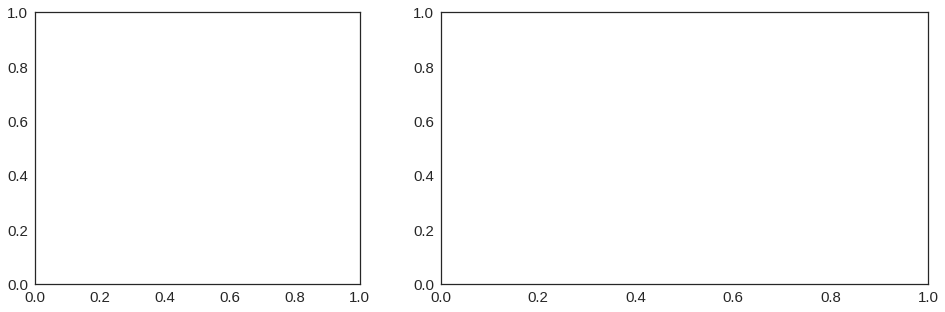

In [35]:
fig = plt.figure(figsize=wide_fig_size)
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5]) 
axs = []
axs.append(plt.subplot(gs[0]))
axs.append(plt.subplot(gs[1]))

# axs[0].annotate('(a)', xy=(0, 1), xycoords='axes fraction', fontsize=18,
#     xytext=(-40, 30), textcoords='offset points',
#     ha='left', va='top')

axs[0].set_title('(a) MNIST-1-7: attack on data-dep defense', fontsize=14)
axs[0].plot(mnist_epsilons, mnist_upper_total_losses, label='$U^*$ (oracle)', linestyle='--', color=palette[4])
axs[0].plot(mnist_epsilons, mnist_slab_upper_total_losses, label='$U^*$ (data-dependent)', linestyle='--', color=palette[0])
axs[0].plot(mnist_epsilons, mnist_slab_lower_total_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c \cup \mathcal{D}_p$)', color=palette[0])
axs[0].plot(mnist_epsilons, mnist_slab_lower_avg_good_train_losses, label='Atk: train loss $L(\hat\\theta; \mathcal{D}_c$)', color=palette[1])
axs[0].plot(mnist_epsilons, mnist_slab_lower_test_losses, label='Atk: test loss $\mathbf{L}(\hat\\theta)$', color=palette[2])
axs[0].set_ylabel('Hinge loss', fontsize=14)
axs[0].legend(bbox_to_anchor = [-0.02, 1.03], loc='upper left', fontsize=14,
              labelspacing=0.15, handletextpad=0.4)
axs[0].set_xlabel('$\epsilon$ (fraction of poisoned data added)', fontsize=14)

###################

plot = plotter.Plotter(
    X_train,
    axes=np.concatenate(
        (np.reshape(datadef.true_centroid_vec, (1, -1)),
        np.reshape(datadef.emp_centroid_vec, (1, -1))), 
        axis=0),
    figsize=(7.5, 6),
    padding=4.5,
    fig=fig,
    ax=axs[1])

plt.xlim((-10, 7.5))
plt.ylim((-12.5, 0))
plot.plot_points_train(X_train, Y_train, alpha=0.2, subsample=0.15)
poison_idx_start = 3700
poison_idx_end = 3701
plot.plot_points_poison(
    X_poison[poison_idx_start:poison_idx_end, :], Y_poison[poison_idx_start:poison_idx_end], 
    linewidth=4, alpha=1,
    poscolor='red',
    negcolor='blue',
    marker='x',
    size=300)

plt.xlabel('Distance along vector between true centroids', fontsize=14)
plt.ylabel('Distance along orthonormal vector', fontsize=14)

for y in set(Y_train):
    class_idx = class_map[y]
    if y == 1:
        color = 'red'
    else:
        color = 'blue'
    
    true_centroid = datadef.true_centroids[class_idx, :]
    slab_radius = slab_radii[class_idx]
    sphere_radius = sphere_radii[class_idx]

    if y == 1:
        class_label = '-1'
    else:
        class_label = '+1'
        
    plot.plot_points_poison(true_centroid, [y], size=150, linewidth=4, alpha=1, marker='o', label='$\mu_{%s}$' % class_label)
    true_centroid_left = plot.proj(true_centroid, 0) - slab_radius
    true_centroid_right = plot.proj(true_centroid, 0) + slab_radius
    
    emp_centroid = datadef.emp_centroids[class_idx, :]
    if y == 1:        
        plot.plot_points_poison(emp_centroid, [y], size=150, linewidth=4, alpha=1, marker='D', 
                            poscolor='red', negcolor='blue',
                            edgecolor='black',
                            label='$\hat\mu_{%s}$' % class_label)
    
        plot.draw_line(x0=true_centroid_left, x1=true_centroid_left, color=color, alpha=0.5, linestyle='--', linewidth=1)
        plot.draw_line(x0=true_centroid_right, x1=true_centroid_right, color=color, alpha=0.5, linestyle='--', linewidth=1)
        
    if y == 1:
        slab_height = 6.4
        wedge_deg = 15
    else:
        slab_height = 5
        wedge_deg = 12
    proj_true_centroid = plot.proj(true_centroid)
    proj_emp_centroid = plot.proj(emp_centroid)


    true_rect = patches.Rectangle(
        (proj_true_centroid[0] - slab_radius, proj_true_centroid[1] - slab_height), 
        slab_radius * 2, slab_height * 2,
        color=color,
        alpha=0.1)
    true_circle = plt.Circle(
        proj_true_centroid, sphere_radius, 
        fill=False, edgecolor=color, linewidth=1, linestyle='--', alpha=0.5) 
    
    emp_polygon = patches.Polygon(
        np.array([
            [-5.97, -3.8],
            [-4.8, -2.33],            
            [-3.63, -1.5],
            [5.27, -10.4],
            [4.25, -11.7],
            [3.23, -12.5],
            [2.81, -12.5]]),     
        color='orange',
        alpha=0.3)
    emp_circle = plt.Circle(
        proj_emp_centroid, sphere_radius, 
        fill=False, edgecolor='orange', linewidth=1, linestyle='--', alpha=0.5)
    fig = plt.gcf()
    ax = fig.gca()

    if y == 1:
        arrow_padding = 0.2
        ax.arrow(
            (1 - arrow_padding) * proj_true_centroid[0] + arrow_padding * proj_emp_centroid[0],
            (1 - arrow_padding) * proj_true_centroid[1] + arrow_padding * proj_emp_centroid[1],
            (2*arrow_padding - 1) * proj_true_centroid[0] + (1 - 2*arrow_padding) * proj_emp_centroid[0],
            (2*arrow_padding - 1) * proj_true_centroid[1] + (1 - 2*arrow_padding) * proj_emp_centroid[1],        
            width=0.1,
            length_includes_head=True,
            color='black',
            zorder=4
        )
    
        ax.add_artist(true_rect)
        ax.add_artist(true_circle)
        ax.add_artist(emp_circle)
        ax.add_artist(emp_polygon)        
        plot.draw_plane(datadef.emp_centroid_vec, emp_centroid, slab_radius, color='orange')
        plot.draw_plane(datadef.emp_centroid_vec, emp_centroid, -slab_radius, color='orange')

# annotate_upper_left(axs[1], '(b)')

plt.title('(b) MNIST-1-7: effect of shifting centroids', fontsize=14)
plt.legend(fontsize=16)
plt.rcParams['font.sans-serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = 'serif'
plt.savefig(
    os.path.join(fig_root, 'paper-fig4.pdf'), 
    dpi=300, bbox_inches='tight')
